In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from itertools import product

import lsrl
from lsrl.matrix_tools import Matrix, MatrixMode, set_global_matrix_mode

/homes/cdt21/aleks/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


This notebook illustrates the construction of the universal in-context approximator model for continous functions. This follows closely Lst. 1 in the paper. Note that we are implementing it only with the original (ReLU, unoptimized) `f_ifelse`. The rest of the `f_ifelse` implementations and extensive testing with both the symbolic and numeric modes are available in `test_ua_vec2vec.py`.

In [2]:
# This sets all the computations to be symbolic.
set_global_matrix_mode(MatrixMode.SYMBOLIC)

Let's build the program:

In [3]:
target_fun_input_dim = 2
target_fun_output_dim = 1

# input dimension is such that we can express the
# discretization size (1/N), the current cell location and the
# output value of the self.target function at that cell
input = lsrl.Input(dim=1 + target_fun_input_dim + target_fun_output_dim)

# constant 1 that we will need for the counter
const_1 = lsrl.f_constant(input, 1)

# this counter gives us the current input number
# we use it to differentiate between the input at position 1 and the self.prompts at positions > 1
counter = lsrl.LinState(
    input=const_1,
    A=Matrix.eye(1),
    B=Matrix.eye(1),
    init_state=Matrix.zeros(1, 1),
    name="Counter",
)

# we have to up-project the counter and the const vector as we don't support broadcasting (yet)
counter_vector = lsrl.Linear(
    input=counter,
    A=Matrix.ones(target_fun_input_dim, 1),
    b=Matrix.zeros(target_fun_input_dim, 1),
    name="CounterVector",
)
large_constant = 1e10
scale = 1000

x_update = lsrl.f_ifelse(
    lsrl.f_smaller(counter_vector, 1.5, scale=scale),
    t_val=input[: target_fun_input_dim],
    f_val=input[: target_fun_input_dim] * 0,
    large_constant=large_constant
)

x = lsrl.LinState(
    input=x_update,
    A=Matrix.eye(target_fun_input_dim),
    B=Matrix.eye(target_fun_input_dim),
    init_state=Matrix.zeros(target_fun_input_dim, 1),
    name="x",
)

# now we can process the prompt inputs
# note that we should ignore the first input as it is the x

# we need the lower bound and the upper boundaries for the current cell
# the lower bound is directly given in the prompt tokens
# the upper bound we get by adding 1/N to the lower bound

# broadcast the step size to the input dimension
step_size = lsrl.Linear(
    input[0],
    Matrix.ones(target_fun_input_dim, 1),
    Matrix.zeros(target_fun_input_dim, 1),
    name="StepSizeBroadcast",
)
lb = input[1 : 1 + target_fun_input_dim]
ub = lb + step_size

# we can now create the bump function that checks if x is in this cell
x_in_bump_componentwise = lsrl.f_bump(x, lb, ub, scale=scale)

# this would be component-wise test so we need to check if all entries are 1
bump_sum = lsrl.Linear(
    input=x_in_bump_componentwise,
    A=Matrix.ones(1, target_fun_input_dim),
    b=Matrix.zeros(1, 1),
    name="BumpSum",
)

# if the bump sum is equal to self.target_fun_input_dim we are in the cell
# and if the counter is > 1 we are in the state of processing the self.prompts
# so we can update the output
in_cell = lsrl.f_larger(bump_sum, target_fun_input_dim - 0.5, scale=scale)
in_cell_and_processing = lsrl.f_and(in_cell, lsrl.f_larger(counter, 0.5, scale=scale), scale=scale)

# again, we need to up-project in_cell_and_processing to the output dimension as we do not support broadcasting
in_cell_and_processing_vector = lsrl.Linear(
    input=in_cell_and_processing,
    A=Matrix.ones(target_fun_output_dim, 1),
    b=Matrix.zeros(target_fun_output_dim, 1),
    name="InCellAndProcessingVector",
)
const_1_vector_out = lsrl.Linear(
    input=const_1,
    A=Matrix.ones(target_fun_output_dim, 1),
    b=Matrix.zeros(target_fun_output_dim, 1),
    name="Const1Vector",
)

update = lsrl.f_ifelse(
    lsrl.f_larger(in_cell_and_processing_vector, 0.5, scale=scale),
    t_val=input[target_fun_input_dim + 1 :],
    f_val=input[target_fun_input_dim + 1 :] * 0,
    large_constant=large_constant
)

# we can now update the output
y = lsrl.LinState(
    input=update,
    A=Matrix.eye(target_fun_output_dim),
    B=Matrix.eye(target_fun_output_dim),
    init_state=Matrix.zeros(target_fun_output_dim, 1),
    name="Output",
)

loop = lsrl.ForEach(output=y)

We can now visualize the computation graph (the DAG) of the above program:

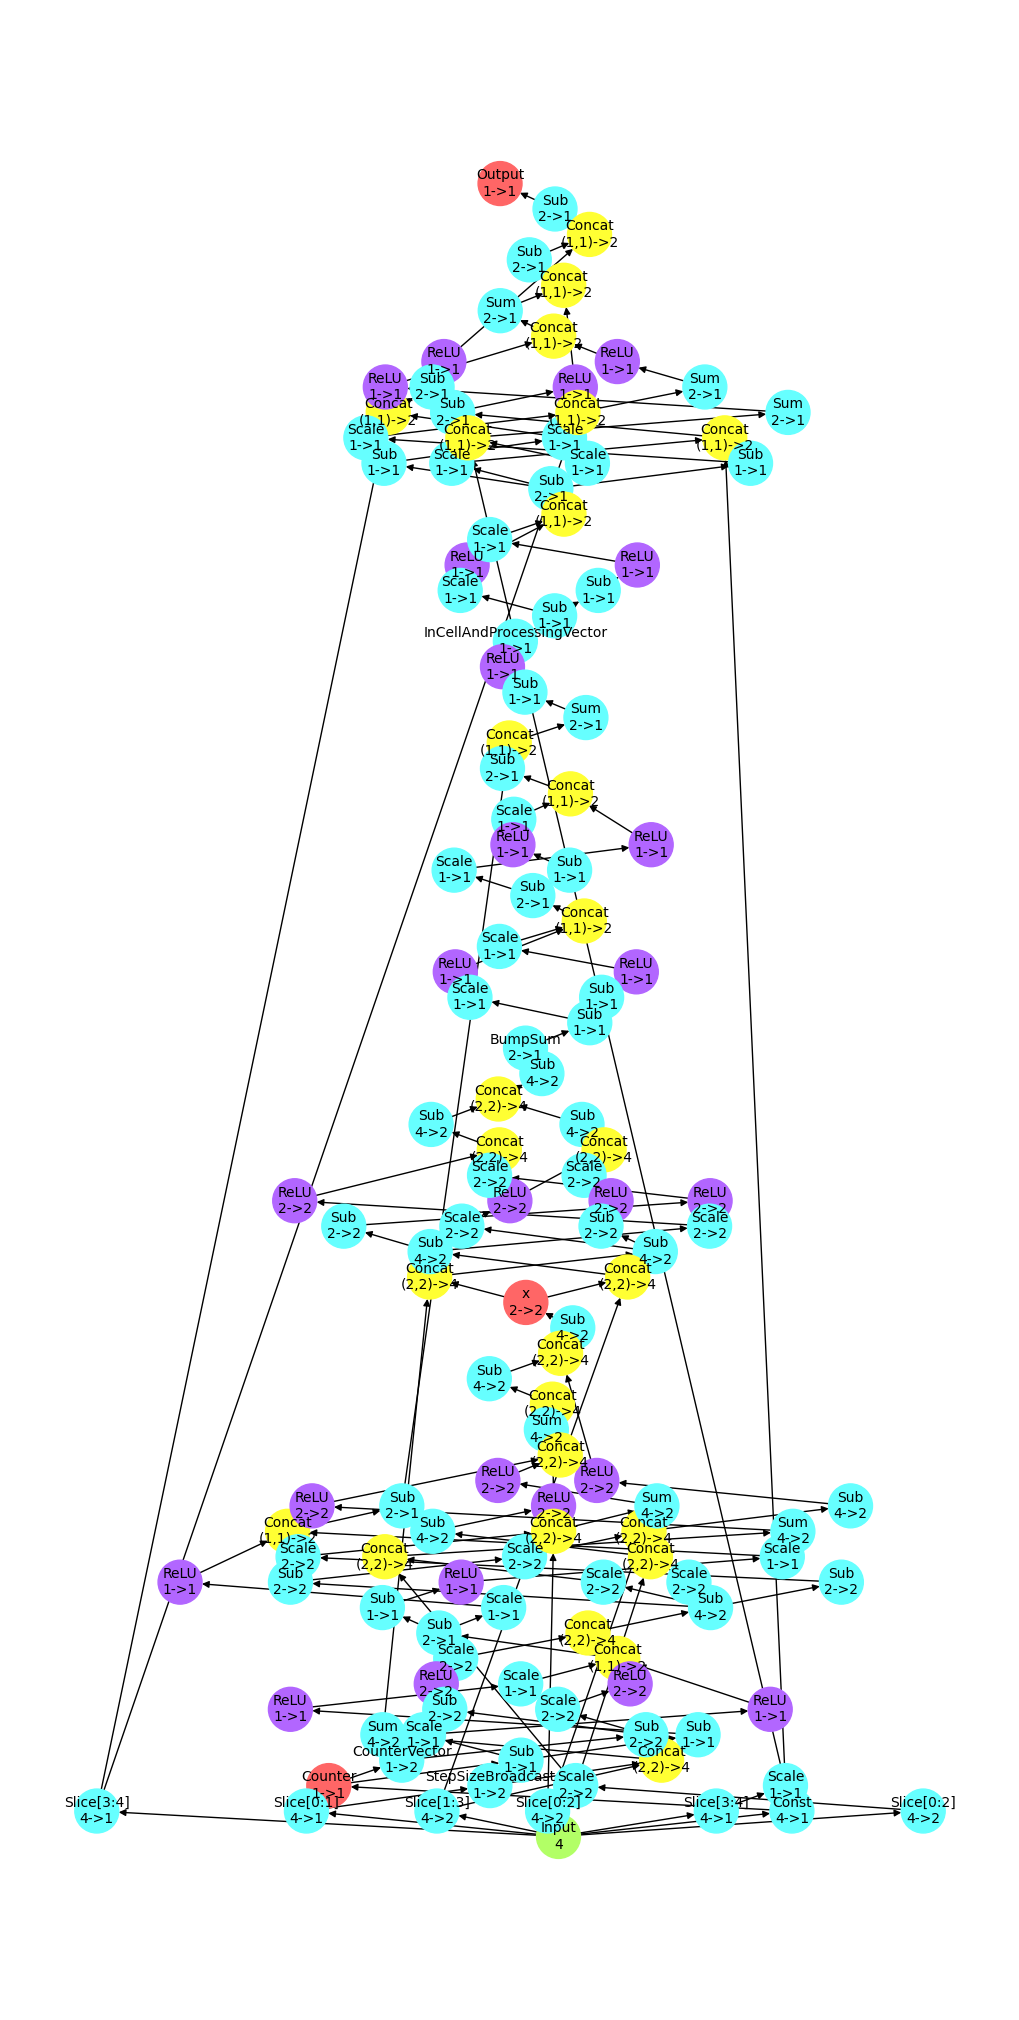

In [4]:
lsrl.utils.plot_and_save_graph(loop.graph(), figsize=(10,20))

As you can see, it has a lot of branching and hence cannot directly be represented as neural network.
We can thus apply the debranching procedure outlined in the paper and compile this computation graph to a path graph that has a natural representation as a neural network model.

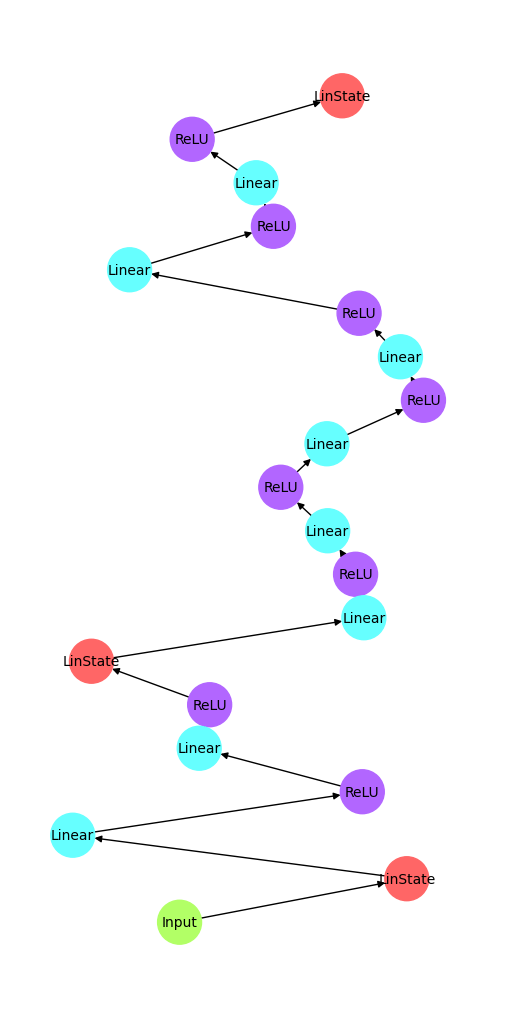

In [5]:
loop.verbose = False
loop.simplify()
lsrl.utils.plot_and_save_graph(loop.graph(), figsize=(5,10), node_types_instead_of_name=True)

Thanks to this simplification step you can see that the underlying model is much more simple: it requires only three linear state variables and two MLPs between them!

Now, lets evaluate that the model is correct, in other words that it does what we expect it to do: approximate a given target function. We create a test target function, and evaluate it at a number of points to show that our approximation is correct.

In [6]:
# # these are some utilities to speed up the evaluation
import multiprocessing
def run_instance(filename, x_vals, prompts):
    loop = lsrl.ForEach.load(filename)
    target_fun_output_dim = loop.input.dim - 1 - x_vals.shape[1]
    results = []
    for x_val in x_vals:
        first_input = np.concatenate((x_val, np.zeros(target_fun_output_dim + 1)))
        full_inputs = np.vstack((first_input, prompts))
        outputs = loop(full_inputs.T)
        results.append(outputs.numpy()[:, -1])
    return results

def run_parallel(filename: str, x_values, prompts):
    num_processes = min(multiprocessing.cpu_count() // 2, len(x_values))
    pool = multiprocessing.Pool(processes=num_processes)
    x_vals_split = np.array_split(x_values, num_processes)
    results = pool.starmap(run_instance, [(filename, x_vals, prompts) for x_vals in x_vals_split])
    pool.close()
    pool.join()
    return np.vstack(results).squeeze()

In [7]:
# Create the test target function
target = lsrl.utils.create_test_target_function(
    in_dim=target_fun_input_dim,
    out_dim=target_fun_output_dim,
    n_control_points=5,
    smoothness=1,
)
discretization_levels = 6
prompt = lsrl.utils.construct_prompt(
    target,
    in_dim=target_fun_input_dim,
    out_dim=target_fun_output_dim,
    N=discretization_levels,
)

# Compute the target function at a grid of points
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
x_centers = (x[:-1] + x[1:]) / 2
y_centers = (y[:-1] + y[1:]) / 2
Z = np.zeros((len(x_centers), len(y_centers), target_fun_output_dim))
for i, x_val in enumerate(x_centers):
    for j, y_val in enumerate(y_centers):
        Z[i, j] = target([x_val, y_val])


# Evaluate the LSRL program at the same points and plot that too
x = np.linspace(0, 1, 18)
y = np.linspace(0, 1, 18)
x_centers = (x[:-1] + x[1:]) / 2
y_centers = (y[:-1] + y[1:]) / 2
Z_eval = np.zeros((len(x_centers), len(y_centers), target_fun_output_dim))
ij_x_vals = np.array(
    [[i, j, x_val, y_val] for (i, x_val), (j, y_val) in product(enumerate(x_centers), enumerate(y_centers))]
)
loop.save("vec2vec.model")
results = run_parallel("vec2vec.model", ij_x_vals[:, -2:], prompt)

for loc_x_y, res in zip(ij_x_vals, results):
    i, j, x_val, y_val = loc_x_y
    Z_eval[int(i), int(j)] = res


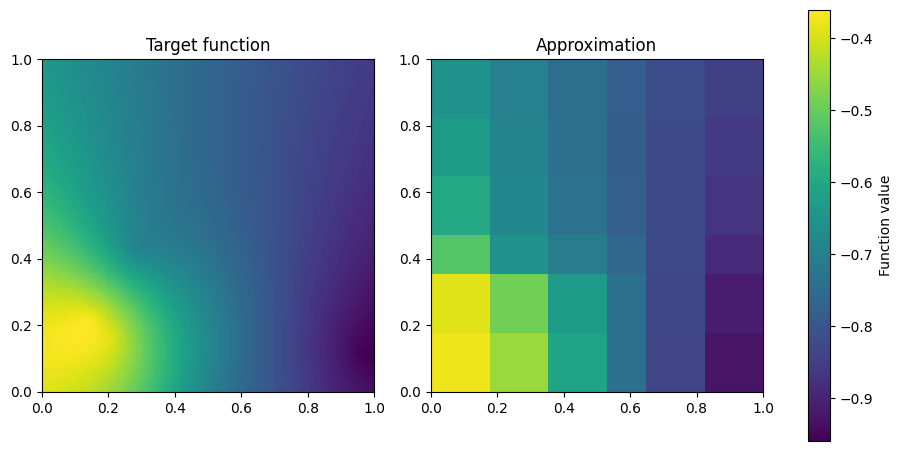

In [8]:
# Plot both
vmin = min(Z.min(), Z_eval.min())
vmax = max(Z.max(), Z_eval.max())
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
cax1 = ax1.imshow(Z[:, :, 0], aspect='equal', vmin=vmin, vmax=vmax, extent=[0, 1, 0, 1])
ax1.set_title("Target function")

cax2 = ax2.imshow(Z_eval[:, :, 0], aspect='equal', vmin=vmin, vmax=vmax, extent=[0, 1, 0, 1])
ax2.set_title("Approximation")

# Make both subplots square
ax1.set_aspect('equal', 'box')
ax2.set_aspect('equal', 'box')

# Adjust layout to make room for the colorbar
fig.tight_layout(pad=2)

# Add a single colorbar for both subplots
cbar = fig.colorbar(cax2, ax=[ax1, ax2], orientation='vertical')
cbar.set_label('Function value')

You can see that our model is indeed a piece-wise constant approximation of the target function. And as one increases `discretization_levels`, the resolution of our approximation becomes finer and the approximation error becomes smaller. Hence, for any target approximation error $\epsilon$ there is a `discretization_levels` such that the approximation will be at most $\epsilon$-different from the target. Therefore, our construction is indeed a universal in-context approximator.

You can also see how the prompts are structered as described in the paper. The first element is $\delta$=1/`discretization_levels`, the second and the third describe the lower coordinate of one discretization cell and the last element is the value of `target` at the center of that cell:

In [9]:
for i in range(20):
    print(f"Prompt token {i+1:<5}: {prompt[i]}")

Prompt token 1    : [ 0.16666667  0.          0.         -0.65259949]
Prompt token 2    : [ 0.16666667  0.          0.16666667 -0.69954036]
Prompt token 3    : [ 0.16666667  0.          0.33333333 -0.74250398]
Prompt token 4    : [ 0.16666667  0.          0.5        -0.78040622]
Prompt token 5    : [ 0.16666667  0.          0.66666667 -0.81502862]
Prompt token 6    : [ 0.16666667  0.          0.83333333 -0.8467376 ]
Prompt token 7    : [ 0.16666667  0.16666667  0.         -0.63224909]
Prompt token 8    : [ 0.16666667  0.16666667  0.16666667 -0.69154558]
Prompt token 9    : [ 0.16666667  0.16666667  0.33333333 -0.74106929]
Prompt token 10   : [ 0.16666667  0.16666667  0.5        -0.78182008]
Prompt token 11   : [ 0.16666667  0.16666667  0.66666667 -0.82053382]
Prompt token 12   : [ 0.16666667  0.16666667  0.83333333 -0.85688869]
Prompt token 13   : [ 0.16666667  0.33333333  0.         -0.59694901]
Prompt token 14   : [ 0.16666667  0.33333333  0.16666667 -0.68137936]
Prompt token 15   : 